In [1]:
import numpy as np
import cv2 as cv
from os.path import join
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import Dataset
from tqdm import tqdm

In [2]:
class WebotsCVDataset(Dataset):
    def __init__(self, load_annotation_pth, load_img_dir):
        self.load_img_dir = load_img_dir
        self.img_labels = pd.read_csv(load_annotation_pth, header=0)


    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):

        img_pth = join(self.load_img_dir, '%d.png'%idx)
        img = cv.imread(img_pth, cv.IMREAD_COLOR)
        img = img[:, :, ::-1]
        img= cv.cvtColor(img,cv.COLOR_BGR2GRAY)

        label = self.img_labels.iloc[idx, [1, 2, 3]].to_numpy()
        return img, label


In [3]:
def feature_matching(des1, des2):
    n1, n2 = des1.shape[0], des2.shape[0]
    matcher = cv.BFMatcher()
    matches = matcher.knnMatch(des1, des2, k=2)
    good = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good.append([m])

    matchscore = len(good) / max(n1, n2)
    return matchscore


In [4]:
class SiftSceneRecognizer:
    def __init__(self, min_Ndes=50, newMemoryThresh=0.5, contrastThreshold=0.04, edgeThreshold=0.01):
        self.sift = cv.SIFT_create(nfeatures=min_Ndes, contrastThreshold=contrastThreshold, edgeThreshold=edgeThreshold)
        self.min_Ndes = min_Ndes
        self.newMemoryThresh = newMemoryThresh
        self.obs_list = []

    def observe(self, gray):

        _, des2 = self.sift.detectAndCompute(gray, None)

        # No descriptors
        if des2 is None:
            return -1, 0, False

        # Too few descriptors
        if des2.shape[0] < self.min_Ndes:
            return -1, 0, False

        # Initialize with the first scene memory
        if len(self.obs_list) < 1:
            self.obs_list.append(des2)
            return len(self.obs_list)-1, 0, True
        else:

            all_matchscores = np.zeros(len(self.obs_list))
            for i in range(len(self.obs_list)):
                des1 = self.obs_list[i]
                matchscore = feature_matching(des1, des2)
                all_matchscores[i] = matchscore
            max_id = np.argmax(all_matchscores)
            max_score = all_matchscores[max_id]
            if max_score <= self.newMemoryThresh:   # Add new memory
                self.obs_list.append(des2)
                return len(self.obs_list) - 1, max_score, True
            else:
                return max_id, max_score, False







In [5]:
img_dir = join('data', 'VAE', 'imgs')
annotation_pth = join('data', 'VAE', 'annotations.csv')
dataset = WebotsCVDataset(annotation_pth, img_dir)


In [11]:
min_Ndes=100
newMemoryThresh=0.1
contrastThreshold=0.04
edgeThreshold=0.01
sift = SiftSceneRecognizer(min_Ndes, newMemoryThresh, contrastThreshold, edgeThreshold)
Niters = 10000
sid = np.zeros(Niters)
sval = np.zeros(Niters)
obsnum = np.zeros(Niters)
for i in tqdm(range(Niters)):

    gray, label = dataset[i]
    sid[i], sval[i], noval = sift.observe(gray)
    obsnum[i] = len(sift.obs_list)

unique_sids = np.unique(sid)

 14%|█▍        | 1448/10000 [00:44<04:23, 32.40it/s]


KeyboardInterrupt: 

Number of unique states = 85


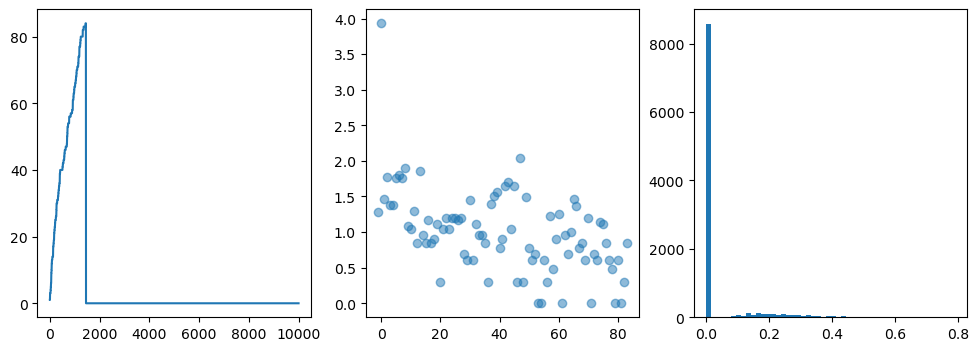

In [12]:
unique_sids, unique_counts = np.unique(sid, return_counts=True)
print('Number of unique states = %d'%(unique_sids.shape[0]))
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].plot(obsnum)
ax[1].scatter(unique_sids, np.log10(unique_counts), alpha=0.5)
_ = ax[2].hist(sval, bins=50)

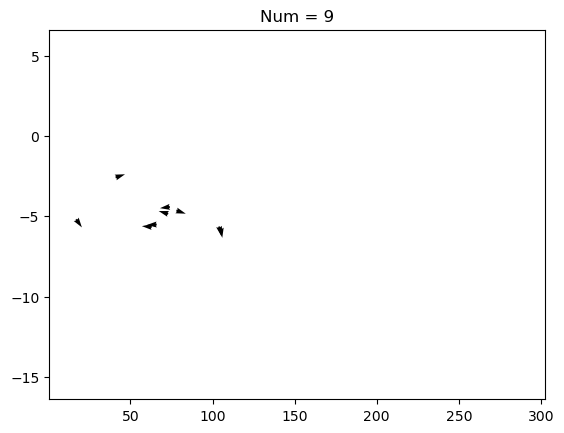

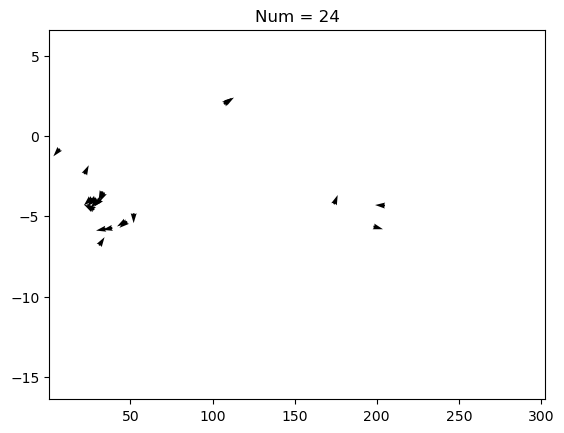

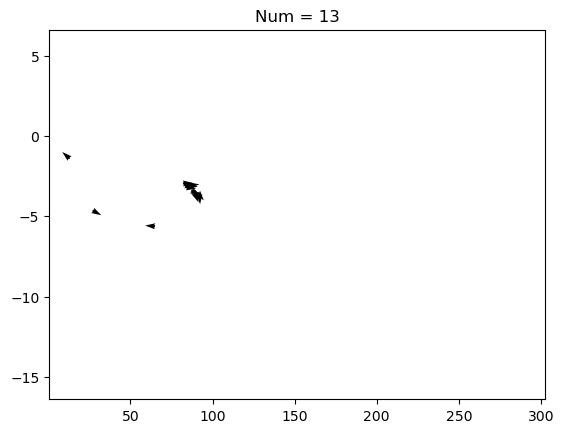

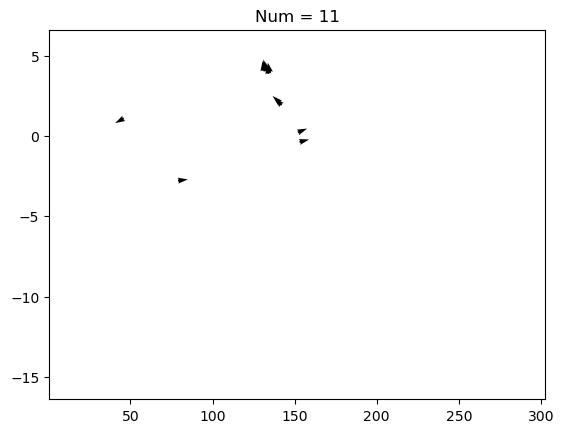

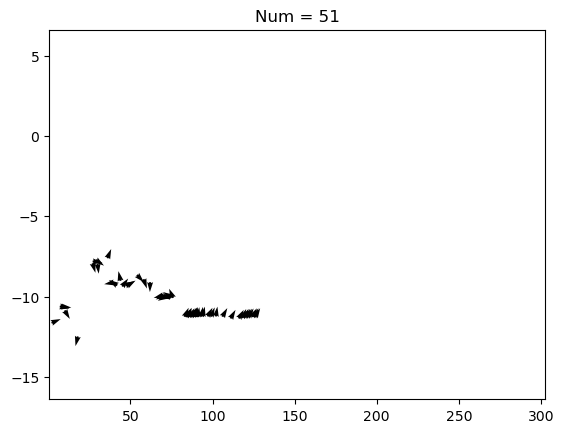

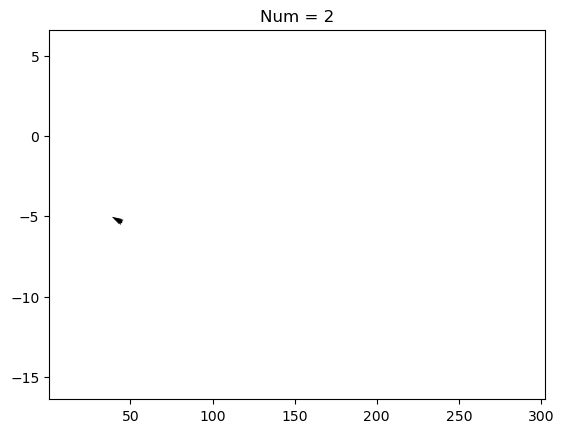

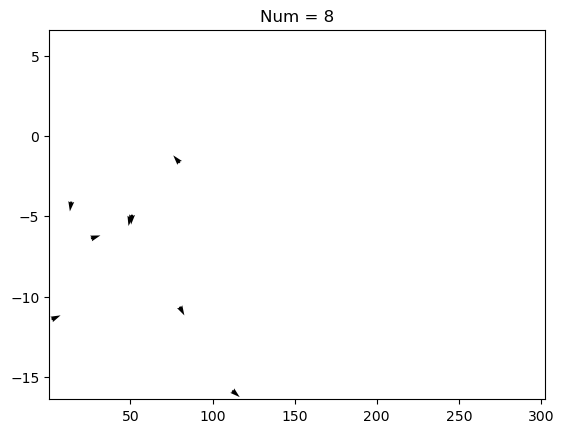

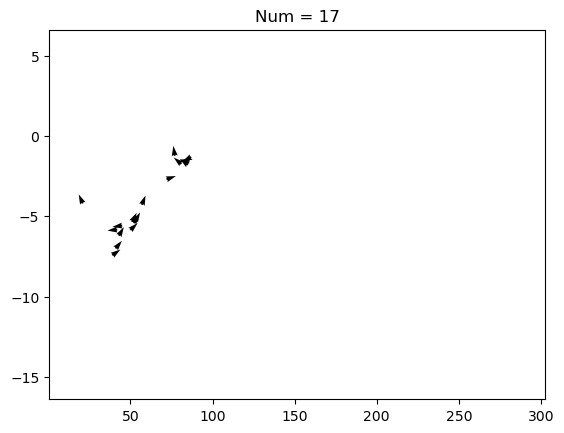

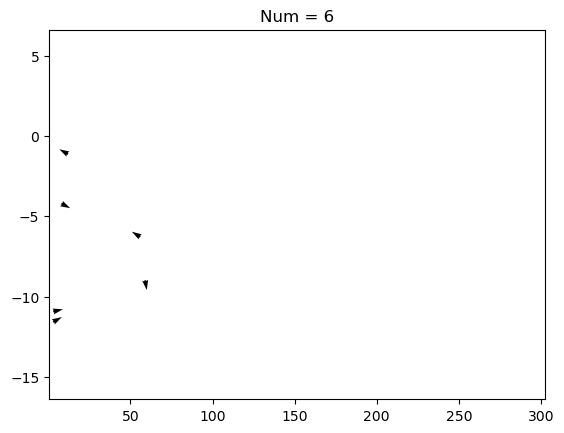

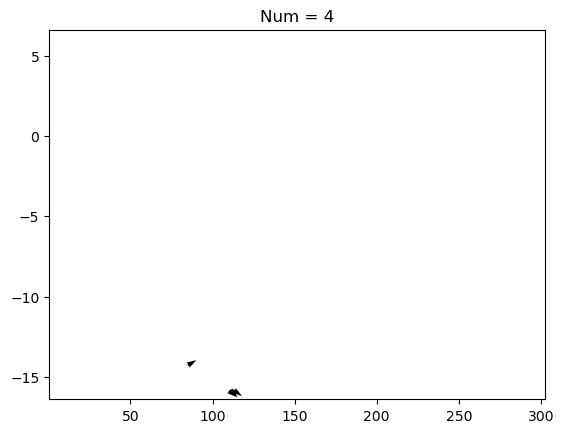

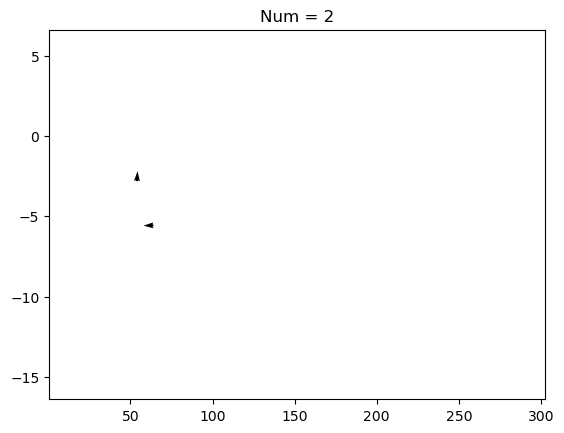

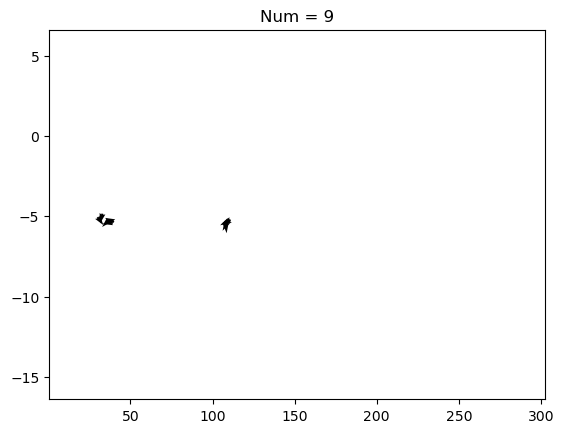

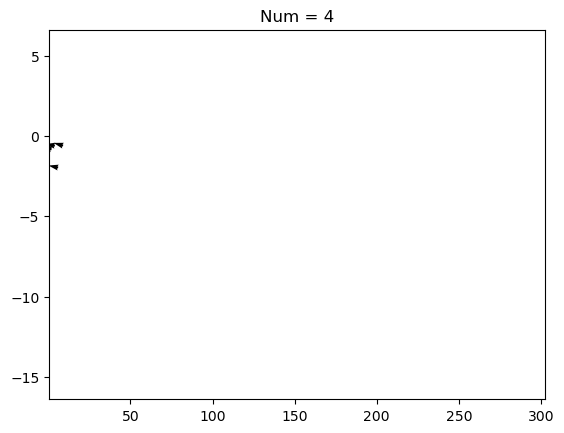

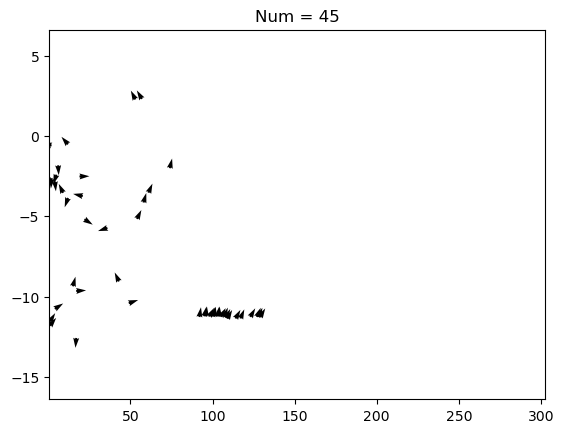

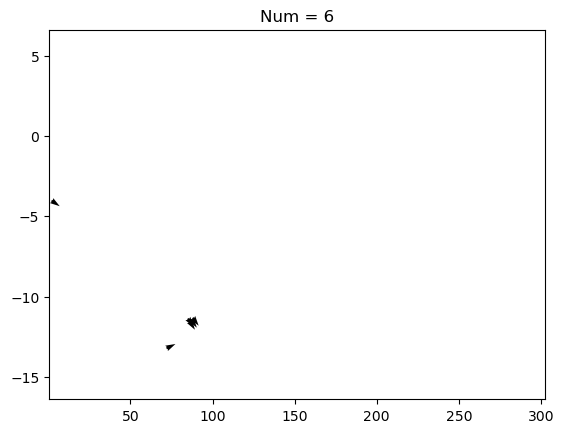

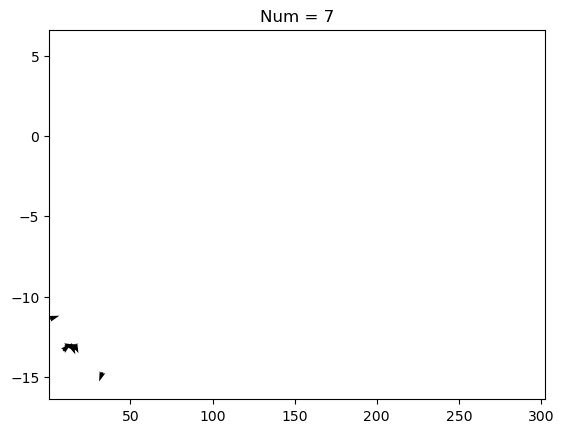

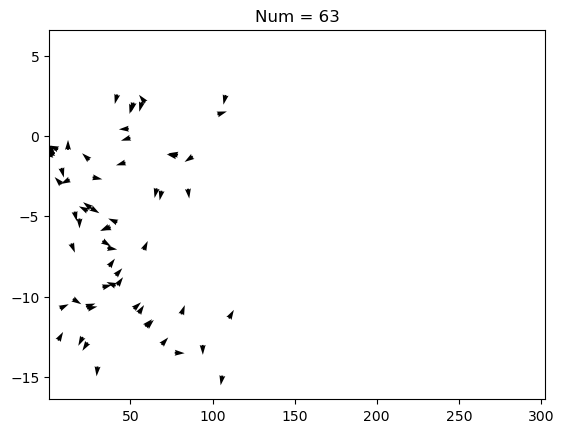

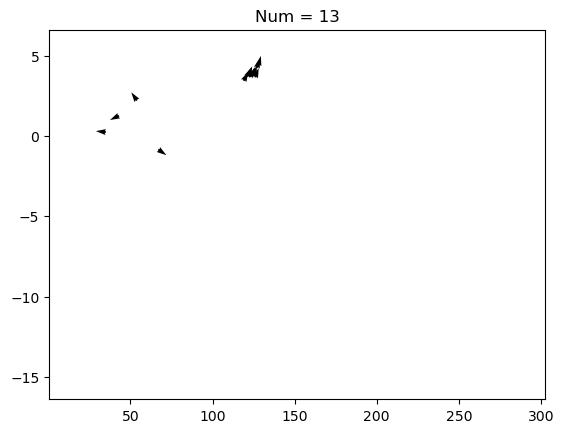

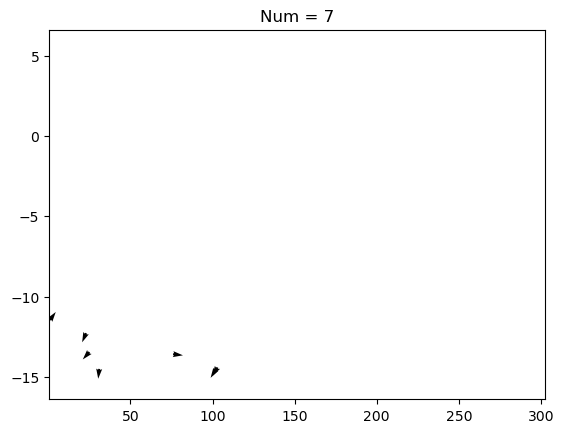

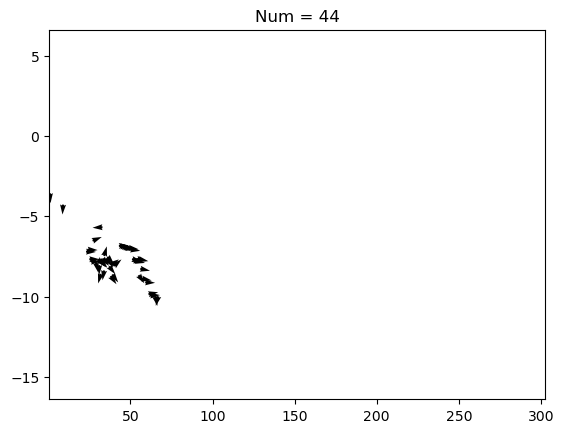

In [13]:
labels = dataset.img_labels.iloc[:Niters, [1, 2, 3]].to_numpy()
x, y, a = labels[:Niters, 0], labels[:Niters, 1], labels[:Niters, 2]

xmin, xmax = x.min(), x.max()
ymin, ymax = y.min(), y.max()

unique_sids = np.unique(sid)
np.random.seed(10)
selected_sids = np.random.choice(len(unique_sids), 20, replace=False)

for sid_each in selected_sids:
    mask = sid == sid_each
    xplot = x[mask]
    yplot = y[mask]
    aplot = a[mask]
    fig, ax = plt.subplots()
    ax.quiver(xplot, yplot, np.cos(aplot), np.sin(aplot), scale=50)
    ax.set_xlim(xmin- 0.5, xmax + 0.5)
    ax.set_ylim(ymin- 0.5, ymax + 0.5)
    ax.set_title('Num = %d'%(mask.sum()))



In [14]:
np.unique(sid)

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
       143., 144., 145., 146., 147., 148., 149., 15

(array([30., 60., 42., 21., 15.,  6.,  2.,  1.,  0.,  1.]),
 array([ 93. , 150.2, 207.4, 264.6, 321.8, 379. , 436.2, 493.4, 550.6,
        607.8, 665. ]),
 <BarContainer object of 10 artists>)

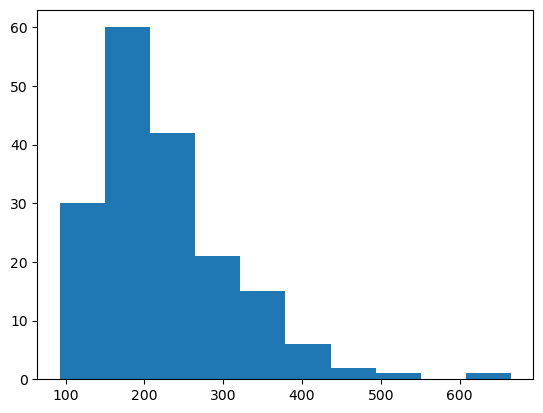

In [13]:
desLs = [len(des) for des in sift.obs_list]

plt.hist(desLs)

In [51]:
sid = sid[:600]
sval = sval[: 600]

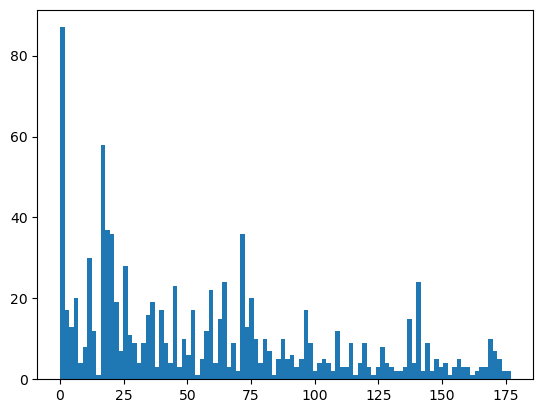

In [9]:
_ = plt.hist(sid, bins=100)